<a href="https://colab.research.google.com/github/som-pat/Resnet-BasevsTL/blob/main/Resnet_50_and_101_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5857%2F2609027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T122811Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D058cdd5c7df9ed986edd86f8eba92aaf15b6371c17ecf02dfb2e41385e3111af7dd49e686234b035e44cdc40e4ef42863038d495712da16e889f5609f3d850b90cb2a07040ab078d7c440a7ef137a51b3e3e742a64a5e838e513bbf8df5ed0e0b1fec12e253369787ca09bb0b7d692b74093c099b3303d9079e9e07485ef00c6b3c7bb33f0580eb28800dadfee1b60b1b435ffc298588181b8d59cb054a48398cf4cbc5d80b4ad4ab09cdc4d8ecc4b0cd74e73c628054e1c9a4e3aba7dc6aaf0637d6f549f0915ccf773015acbab27376da78d6e4af3d89e79fa383b812d5f805ac0344a21cdae750984dc185a1e77a2f93ee885443d9d125c06ae7fd76f4fec'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1379678841 bytes downloaded
Downloaded and uncompressed: fruits
Data source import complete.


 ## **Importing Libraries**

In [2]:
import os
import torch
import numpy
import pandas as pd
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import itertools
from zipfile import ZipFile
from glob import glob
from PIL import Image
import os,random,time,copy
# from resnet import ResidualBlock, ResNet, ResNet50
from tqdm import tqdm

import torch
import torch.nn as  nn
import torch.nn.functional as F

In [3]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
Image_size = [100,100] # Image Size to be used during Augmentation and Normalization
batch_size = 64 # for Dataloader

## Loading Dataset

In [5]:
train_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
test_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'
classes = len(os.listdir(train_path))

* **Dataset Augmentation and Normalization**

In [6]:
# Define a series of transformations for data augmentation and normalization during training
transform_train = transforms.Compose([
    transforms.Resize(Image_size),  # Resize the input image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Apply random affine transformations
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the tensor with specified mean and standard deviation
])

# Define a series of transformations for data normalization during testing/validation
transform_test = transforms.Compose([
    transforms.Resize(Image_size),  # Resize the input image to the specified size
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the tensor with specified mean and standard deviation
])


Reason for difference in Transformation Stacks
> The difference between training and testing transformations lies in the inclusion of data augmentation techniques (e.g., random flipping, rotation, affine transformations) in the training set to enhance model generalization, whereas the test set undergoes only normalization to maintain consistency with real-world scenarios.

In [7]:
# Create datasets for training and testing/validation
train = datasets.ImageFolder(train_path, transform_train)  # Training dataset with data augmentation
test = datasets.ImageFolder(test_path, transform_test)  # Testing/validation dataset with normalization

# Split the training dataset into training and validation subsets
val_len = int(len(train) - 0.25 * len(train))  # Define the length of the validation subset
train, valid = random_split(train, [val_len, len(train) - val_len])  # Randomly split the training data into training and validation subsets


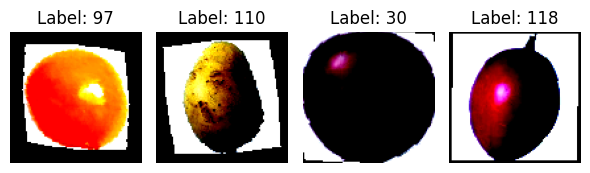

In [8]:
fig, axs = plt.subplots(1,4, figsize=(6, 6))  # Create a horizontal line of subplots
j = random.randint(120,1029)
for i in range(4):
    image, label = train[j+i]
    axs[i].imshow(image.permute(1, 2, 0))   # Display the grayscale image
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()
plt.show()

In [9]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [10]:
image,labels = next(iter(train_loader))
print(image.shape)
print(labels.shape)
print('Classes:',classes)

torch.Size([64, 3, 100, 100])
torch.Size([64])
Classes: 131


## ResNet Architecture

In [11]:
# Define a Residual Block module
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # First convolutional layer with batch normalization and ReLU activation
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        # Second convolutional layer with batch normalization (no activation)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        # Optional downsampling layer
        self.downsample = downsample
        # ReLU activation
        self.relu = nn.ReLU()
        # Store the output channels for later use
        self.out_channels = out_channels

    def forward(self, x):
        # Store the input as residual
        residual = x
        # Pass through the first convolutional layer
        out = self.conv1(x)
        # Pass through the second convolutional layer
        out = self.conv2(out)
        # Apply downsampling if specified
        if self.downsample:
            residual = self.downsample(x)
        # Add the residual to the output
        out += residual
        # Apply ReLU activation
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, blocks, layers, num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 64
        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual layers
        self.layer0 = self.make_layer(blocks, 64, layers[0], stride=1)
        self.layer1 = self.make_layer(blocks, 128, layers[1], stride=2)
        self.layer2 = self.make_layer(blocks, 256, layers[2], stride=2)
        self.layer3 = self.make_layer(blocks, 512, layers[3], stride=2)
        # Adaptive average pooling
        self.ap1 = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    # Helper function to create a layer with multiple residual blocks
    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    # Forward pass through the network
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.ap1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

# Function to create ResNet-50 model
def ResNet50(num_classes):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes)

# Function to create ResNet-101 model
def ResNet101(num_classes):
    return ResNet(ResidualBlock, [3, 4, 23, 3], num_classes)


In [12]:
pre_train50 = ResNet50(classes).to(device)
pre_train101 = ResNet101(classes).to(device)

In [13]:
pre_train50

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [14]:
rnet_50 = pre_train50.to(device)
rnet_101 =pre_train101.to(device)

## Model Training

In [15]:
def model_train(model):


    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    num_epochs = 6
    total_step = len(train_loader)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))


    for epoch in range(1, num_epochs+1):
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0

        ###################
        # train the model #
        ###################

        model.train()
        for images,labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()
            # update training loss
            running_loss += loss.item()*images.size(0)
            _, preds = torch.max(output, 1) # taking the highest value of prediction.
            running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()
        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_acc = running_corrects/ len(train_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        ######################
        # validate the model #
        ######################
        # eval mode (no dropout)
        model.eval()
        with torch.no_grad():
            for val_images,val_labels in tqdm(valid_loader):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_output = model(val_images)
                # calculate the batch loss
                loss = criterion(val_output, val_labels)
                # update average validation loss

                _, val_preds = torch.max(val_output, 1)
                val_running_loss += loss.item()*val_images.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data).detach().cpu().numpy()

        val_epoch_loss = val_running_loss/len(valid_loader.dataset)
        val_epoch_acc = val_running_corrects/ len(valid_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch :', (epoch))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss,epoch_acc))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

    return running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history

In [16]:
running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history = model_train(rnet_50)

100%|██████████| 265/265 [00:32<00:00,  8.20it/s]


epoch : 1
training loss: 3.2488, acc 0.3055 
validation loss: 1.2882, validation acc 0.7471 


100%|██████████| 265/265 [00:31<00:00,  8.34it/s]


epoch : 2
training loss: 0.8605, acc 0.8126 
validation loss: 0.2736, validation acc 0.9564 


100%|██████████| 265/265 [00:32<00:00,  8.28it/s]


epoch : 3
training loss: 0.3136, acc 0.9326 
validation loss: 0.0972, validation acc 0.9846 


100%|██████████| 265/265 [00:31<00:00,  8.37it/s]


epoch : 4
training loss: 0.1581, acc 0.9663 
validation loss: 0.0456, validation acc 0.9927 


100%|██████████| 265/265 [00:32<00:00,  8.23it/s]


epoch : 5
training loss: 0.0987, acc 0.9780 
validation loss: 0.0333, validation acc 0.9933 


100%|██████████| 265/265 [00:32<00:00,  8.20it/s]

epoch : 6
training loss: 0.0731, acc 0.9827 
validation loss: 0.0180, validation acc 0.9966 


 * **Resnet50 Training and Validation Results**

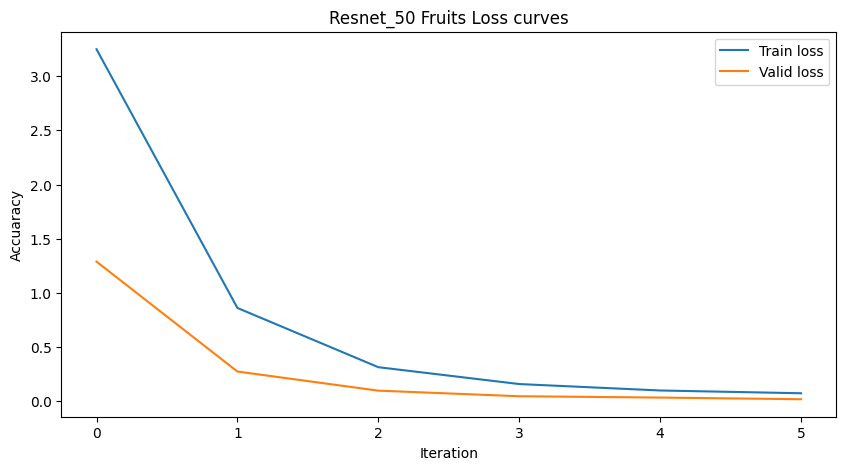

In [17]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_loss_history)
plt.plot(val_running_loss_history)
plt.title("Resnet_50 Fruits Loss curves")
plt.legend(["Train loss", "Valid loss"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

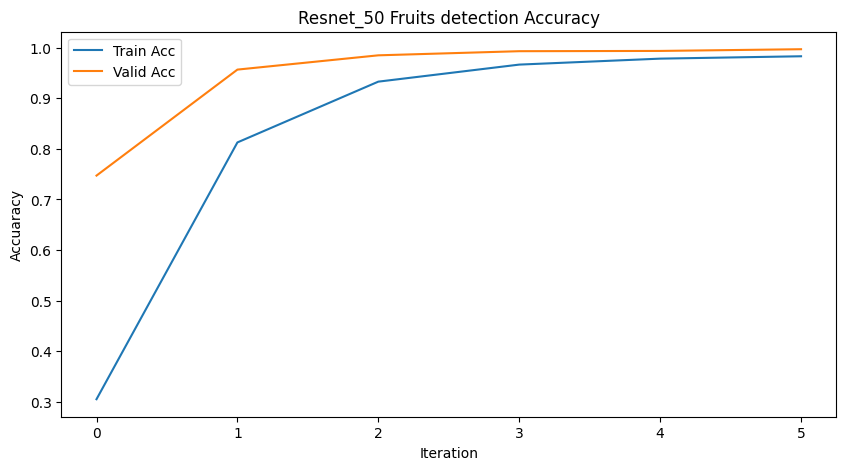

In [18]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_corrects_history)
plt.plot(val_running_corrects_history)
plt.title("Resnet_50 Fruits detection Accuracy")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [19]:
running_loss_history,val_running_loss_history,running_corrects_history,val_running_corrects_history = model_train(rnet_101)

100%|██████████| 265/265 [00:33<00:00,  7.88it/s]


epoch : 1
training loss: 3.5110, acc 0.2269 
validation loss: 1.6338, validation acc 0.6213 


100%|██████████| 265/265 [00:34<00:00,  7.67it/s]


epoch : 2
training loss: 0.9982, acc 0.7725 
validation loss: 0.3358, validation acc 0.9274 


100%|██████████| 265/265 [00:33<00:00,  7.80it/s]


epoch : 3
training loss: 0.3411, acc 0.9179 
validation loss: 0.0965, validation acc 0.9827 


100%|██████████| 265/265 [00:33<00:00,  7.99it/s]


epoch : 4
training loss: 0.1779, acc 0.9565 
validation loss: 0.0575, validation acc 0.9874 


100%|██████████| 265/265 [00:33<00:00,  7.97it/s]


epoch : 5
training loss: 0.1133, acc 0.9719 
validation loss: 0.0397, validation acc 0.9897 


100%|██████████| 265/265 [00:33<00:00,  7.89it/s]

epoch : 6
training loss: 0.0917, acc 0.9760 
validation loss: 0.0169, validation acc 0.9957 


* **Resnet101 Training and Validation Results**

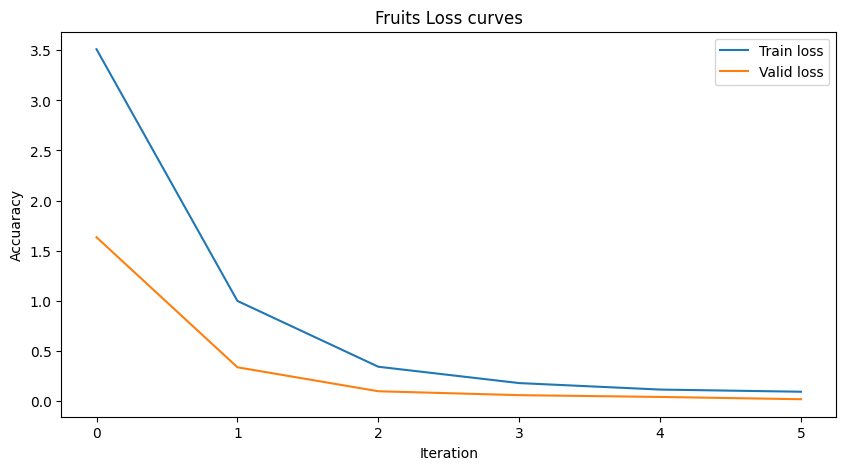

In [20]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_loss_history)
plt.plot(val_running_loss_history)
plt.title("Fruits Loss curves")
plt.legend(["Train loss", "Valid loss"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

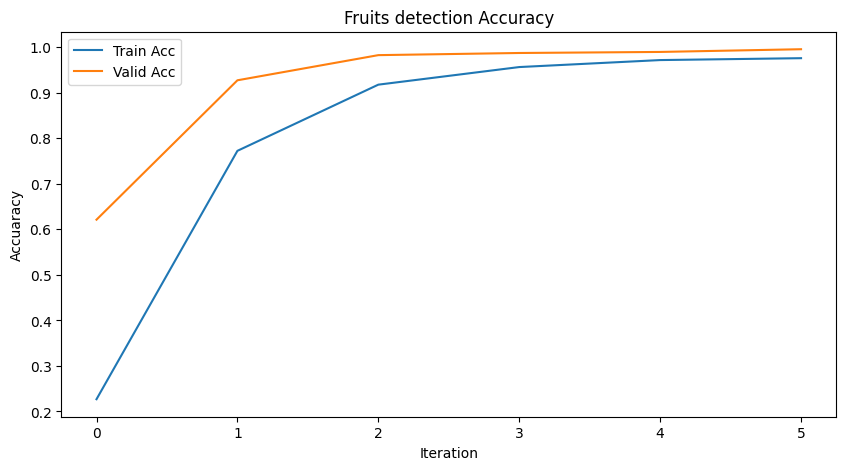

In [21]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(running_corrects_history)
plt.plot(val_running_corrects_history)
plt.title("Fruits detection Accuracy")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

## Model Testing

In [22]:
def model_test(model):

    test_loss = 0.0
    class_correct = list(0. for i in range(classes))
    class_total = list(0. for i in range(classes))
    criterion = nn.CrossEntropyLoss()

    model.eval()

    for image, target in tqdm(test_loader):

        image = image.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
        test_loss += loss.item()*image.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        if len(target) == 64:
            for i in range(64):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

#   for i in range(classes):
#       if class_total[i] > 0:
#           print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#               classes[i], 100 * class_correct[i] / class_total[i],
#               np.sum(class_correct[i]), np.sum(class_total[i])))
#       else:
#           print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

* **Resnet50 Testing Results**

In [23]:
model_test(rnet_50)

100%|██████████| 355/355 [00:33<00:00, 10.50it/s]

Test Loss: 0.155868


Test Accuracy (Overall): 95.3875 (21611.0/22656.0)


* **Resnet101 Testing Results**

In [24]:
model_test(rnet_101)

100%|██████████| 355/355 [00:37<00:00,  9.38it/s]

Test Loss: 0.123641


Test Accuracy (Overall): 96.3630 (21832.0/22656.0)
